In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
def drop_sparse(df, threshold):
    for col in df.columns:
        if df[col].count() < threshold:
            df.drop(col, axis=1, inplace=True)
    return None

def one_hot_encoding(df, columns):
    df = df.copy()
    for col, pref in columns.items():
        dummy = pd.get_dummies(df[col], prefix=pref)
        dummy.astype(bool)
        df = pd.concat([df, dummy], axis=1)
        df = df.drop(col, axis=1)
    return df

In [3]:
horses = pd.read_csv('./data/horses2.csv')

In [4]:
horses = horses.drop(['RaceNumber','RaceName','RaceTitle','Place','HorseName','Trainer', 'Driver', 'Venue', 'DayCalender', 'HorseID',  'Placer','Colour', 'Sire', 'NumberTrainer', 'tracknamelaststart', 'TrainerLastStart','DriverLastStart','StewardsFull', 'racetime', 'Timelastrace',  'Tracklaststart','StewardsComments', 'Prizemoney','Firststarter','DistanceLastStart','Dayssincelast','Handicap', 'RaceDistance','RowLastStart','SameDistance','Standlaststart', 'Triallaststart', 'broken', 'countofdeath','downindistance', 'eveningrace', 'eveningracelaststart', 'morningrace','morningracelaststart', 'totalprize', 'upindistance', 'LeaderStrikeRate', 'RecentPlacings', 'Leading',  'prizemoneydown', 'Gatespeedstrikerate','Prizemoneylastrace', 'trainerchange', 'prizemoneysame', 'Age', 'Deathseat', 'RecentSeconds', 'BestWinningMile', 'driverchange', 'RecentThirds', 'LifetimeWins', 'TimeLead', 'RecentRuns', 'TimeBroken', 'prizemoneyup', 'trials', 'LifetimeSeconds', 'TimeGateSpeed', 'LifetimePlacings' ,'countld1', 'countld2','countld3','countld4','countfront1','countfront2','countfront3','countfront4', 'MarginWinner', 'Margin','start2','start3','start4','sametrack', 'LifetimeThirds', 'startingprice1', 'LifetimeRuns', 'RecentWins', 'PrizemoneyLastStart', 'avestake', 'aveplace', 'LifetimeWinPercent', 'LifetimePlacePercent', 'frontrow','secondrow'], axis=1)


In [5]:
drop_sparse(horses, 10)
horses = one_hot_encoding(horses, {'Row':'Row','Sex': 'Sex'})
horses = horses[['Winner','StartingOdds','RecentPlacePercent','RecentWinPercent','Class','Row_1','laststart','Sex_COLT','Sex_HORSE']]

In [6]:
median = horses.median()
horses.fillna(median, inplace=True)
horses.to_csv('./data/clean_data.csv', index=False)

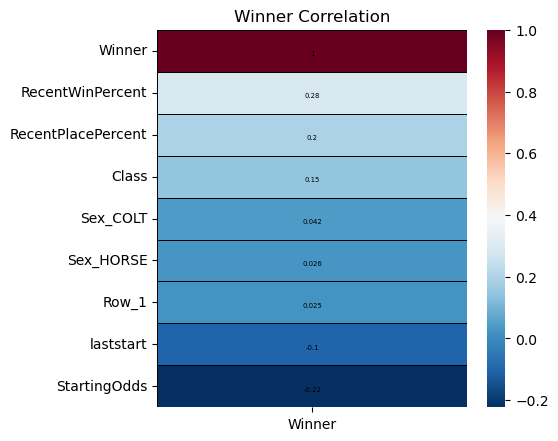

In [7]:
corr = horses.corr().sort_values(by='Winner', ascending=False)
winner_corr = corr[['Winner']]
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
annot_kws = {"ha": 'center',"va": 'top', "size":5, "color": "black"}
ax = sns.heatmap(winner_corr, annot=True, vmax=winner_corr.max(), vmin=winner_corr.min(), square=False, cbar=True, cmap='RdBu_r', linewidths=0.5, linecolor='black', annot_kws=annot_kws)
ax.set_title('Winner Correlation')
plt.show()

In [8]:
horses.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144917 entries, 0 to 144916
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Winner              144917 non-null  int64  
 1   StartingOdds        144917 non-null  float64
 2   RecentPlacePercent  144917 non-null  float64
 3   RecentWinPercent    144917 non-null  float64
 4   Class               144917 non-null  int64  
 5   Row_1               144917 non-null  uint8  
 6   laststart           144917 non-null  int64  
 7   Sex_COLT            144917 non-null  uint8  
 8   Sex_HORSE           144917 non-null  uint8  
dtypes: float64(3), int64(3), uint8(3)
memory usage: 7.0 MB


In [9]:
horses.head()

,Winner,StartingOdds,RecentPlacePercent,RecentWinPercent,Class,Row_1,laststart,Sex_COLT,Sex_HORSE
0,0,91.0,0.192308,0.038462,50,0,8,0,0
1,0,16.0,0.500000,0.166667,75,0,8,0,0
2,0,61.0,0.000000,0.000000,50,1,0,0,0
3,1,6.5,0.200000,0.100000,87,0,1,0,1
4,0,9.0,0.000000,0.000000,83,1,2,0,0


In [10]:
x = horses.drop(['Winner'], axis=1)
y = horses['Winner']
x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
lr = LogisticRegression(solver='newton-cg').fit(x_train, y_train)
print(f'Logistic Regression: {lr.score(x_test, y_test)*100}%')

Logistic Regression: 88.8662710460944%


In [12]:
input = tf.keras.Input(shape=(x.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu')(input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
nn_model = tf.keras.Model(input, output)
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/10


2022-06-25 23:13:38.109822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 23:13:38.109938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-25 23:13:38.224760: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   1/3623 [..............................] - ETA: 25:44 - loss: 0.7136 - accuracy: 0.3438

2022-06-25 23:13:38.500204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3623/3623 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.8913

2022-06-25 23:14:02.142912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3623/3623 [==============================] - 27s 7ms/step - loss: 0.2749 - accuracy: 0.8913 - val_loss: 0.2663 - val_accuracy: 0.8909
Epoch 2/10
3623/3623 [==============================] - 26s 7ms/step - loss: 0.2656 - accuracy: 0.8931 - val_loss: 0.2644 - val_accuracy: 0.8898
Epoch 3/10
3623/3623 [==============================] - 26s 7ms/step - loss: 0.2636 - accuracy: 0.8940 - val_loss: 0.2691 - val_accuracy: 0.8867
Epoch 4/10
3623/3623 [==============================] - 25s 7ms/step - loss: 0.2627 - accuracy: 0.8945 - val_loss: 0.2636 - val_accuracy: 0.8927
Epoch 5/10
3623/3623 [==============================] - 26s 7ms/step - loss: 0.2621 - accuracy: 0.8947 - val_loss: 0.2636 - val_accuracy: 0.8906
Epoch 6/10
3623/3623 [==============================] - 25s 7ms/step - loss: 0.2614 - accuracy: 0.8945 - val_loss: 0.2640 - val_accuracy: 0.8917
Epoch 7/10
3623/3623 [==============================] - 25s 7ms/step - loss: 0.2614 - accuracy: 0.8951 - val_loss: 0.2636 - val_accuracy: 0.8

In [13]:
def test_db(names,model):
    scores = {}
    for name in names:
        horses_test = pd.read_csv(f'./data/{name}.csv')
        try:
            horses_test = one_hot_encoding(horses_test, {'Row':'Row','Sex': 'Sex'})
        except:
            horses_test = one_hot_encoding(horses_test, {'Row':'Row','sex': 'Sex'})
        horses_test = horses_test[['Winner','StartingOdds','RecentPlacePercent','RecentWinPercent','Class','Row_1','Sex_COLT','Sex_HORSE','laststart']]
        median_test = horses_test.median()
        horses_test.fillna(median_test)
        x_eval = horses_test.drop(['Winner'], axis=1)
        y_eval = horses_test['Winner']
        x_eval = pd.DataFrame(StandardScaler().fit_transform(x_eval), columns=x_eval.columns)
        scores.update({name: model.evaluate(x_eval, y_eval,verbose=0)})
    return scores

In [14]:
test_scores = test_db(['horses','horses1'], nn_model)

2022-06-25 23:17:58.155570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/wg/0kpf4bq56tn3zqg0vq6863980000gn/T/ipykernel_20186/3407479705.py:4: DtypeWarning: Columns (16,17,18,19,20,21,22,96) have mixed types. Specify dtype option on import or set low_memory=False.
  horses_test = pd.read_csv(f'./data/{name}.csv')


In [15]:
db = list(test_scores.keys())
print(f'{db[0]}: {round(test_scores["horses"][1]*100)}%')
print(f'{db[1]}: {round(test_scores["horses1"][1]*100)}%')

horses: 89%
horses1: 86%


In [16]:
nn_model.save_weights('./checkpoints/my_checkpoint')